# Machine Learning Lab 5 - Clustering
Adapted From Dr. Haiguang Huang (Wenzhou University)：
https://github.com/fengdu78/WZU-machine-learning-course

Tutor: Dr. Xiaorui Jiang

## K-Means Clustering

K-means algorithm starts by guessing the initial cluster centroid for each cluster, then repeatedly assigns the instance to the nearest cluster, and recomputes the cluster centroid for that cluster. 


### K-Means Implementation from Scratch

Prepare some data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat

In [2]:
# If you use Google Colab, please create a folder called "data" in the Files panel at the 
# left-hand side of the brower, and upload ex7dara2.csv to it
# Then, you need to modify the path to '/content/data/ex7data2.csv'

data2 = pd.read_csv('data/ex7data2.csv')
data2.head()

,X1,X2
0,1.842080,4.607572
1,5.658583,4.799964
2,6.352579,3.290854
3,2.904017,4.612204
4,3.231979,4.939894


In [3]:
X = data2.values

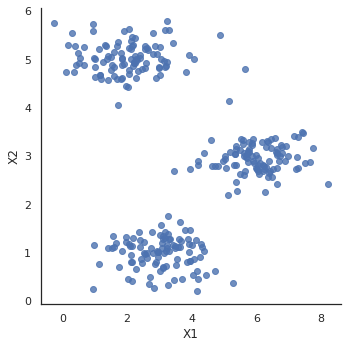

In [4]:
sb.set(context="notebook", style="white")
sb.lmplot(x='X1', y='X2', data=data2, fit_reg=False)
plt.show()

The function that finds the closest cluster center for each instance in the data.

In [5]:
def find_closest_centroids(X, centroids):
    """
    Parameter X: (N, D)
    Parameter centroids: (k, D)
    Return: assignments -- the assignments of each data point to the closest centroid (i.e, the id of the centroid)
    """
    N = X.shape[0]
    k = centroids.shape[0]
    assignments = np.zeros(N)

    for i in range(N):
        min_dist = 1000000000
        for j in range(k):
            dist = np.sum((X[i, :] - centroids[j, :])**2)
            # dist = np.linalg.norm(X[i] - centroids[j]) # another way of calculating Eulidean distance
            if dist < min_dist:
                min_dist = dist
                assignments[i] = j

    return assignments

Test and check that the find_closest_centroids functions works properly

In [6]:
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]]) # initialised to have 3 clusters

close_centroids = find_closest_centroids(X, initial_centroids)
close_centroids[0 : 3]

array([0., 2., 1.])

Computes the cluster centers of the clusters. The cluster centre is simply the average of all samples assigned to the cluster.

In [7]:
def update_centroids(X, assignments, k):
    m, n = X.shape
    centroids = np.zeros((k, n))

    for i in range(k):
        indices = np.where(assignments == i)
        centroids[i, :] = (np.sum(X[indices, :], axis=1) / len(indices[0])).ravel()

    return centroids

In [8]:
update_centroids(X, close_centroids, 3)

array([[2.42830111, 3.15792418],
       [5.81350331, 2.63365645],
       [7.11938687, 3.6166844 ]])

Iterative updating of cluster centroids -- Implementing K-Means

In [9]:
def k_means(X, initial_centroids, max_iters):
    """
    We also need to check the whether the centroids do not change any more
    """
    m, n = X.shape
    k = initial_centroids.shape[0]
    idx = np.zeros(m)
    centroids = initial_centroids
    old_centroids = centroids
    
    for i in range(max_iters):
        assignments = find_closest_centroids(X, centroids)
        centroids = update_centroids(X, assignments, k)
        # check centroids changed
        mask = (centroids == old_centroids).astype('int32')
        # print(mask)
        if mask.sum() == len(mask.ravel()):  # mask is all-True, meaning centroids equal to old_centroids:
            print("Early stop k-means learning at iteration %d because centroids no longer change" % (i))
            break
        old_centroids = centroids
        
    return idx, centroids

In [10]:
# max_iters = 10
assignments, centroids = k_means(X, initial_centroids, 10)

Early stop k-means learning at iteration 6 because centroids no longer change


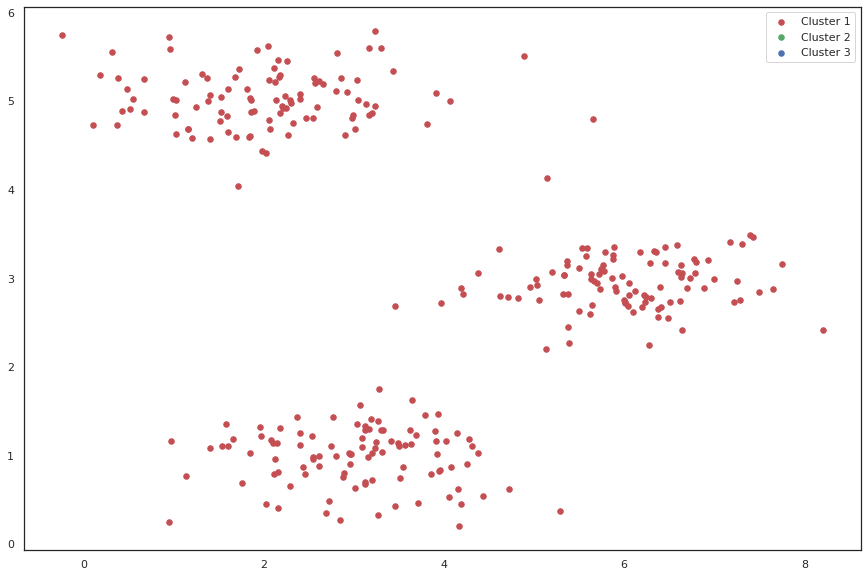

In [12]:
cluster1 = X[np.where(assignments == 0)[0],:]
cluster2 = X[np.where(assignments == 1)[0],:]
cluster3 = X[np.where(assignments == 2)[0],:]

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(cluster1[:,0], cluster1[:,1], s=30, color='r', label='Cluster 1')
ax.scatter(cluster2[:,0], cluster2[:,1], s=30, color='g', label='Cluster 2')
ax.scatter(cluster3[:,0], cluster3[:,1], s=30, color='b', label='Cluster 3')
ax.legend()
plt.show()

We skipped an important step, which is the initialisation of the cluster centroids.
Initialisation greatly affects the algorithm performance, so we usually randomly pick some samples as initial cluster centroids, and try clustering and evaluate them.

In [13]:
def init_centroids(X, k, random_state=42):
    np.random.seed(random_state) #
    
    m, n = X.shape
    centroids = np.zeros((k, n))
    idx = np.random.randint(0, m, k) # randomly genrate k values in [0,m)

    for i in range(k):
        centroids[i, :] = X[idx[i], :]

    return centroids

In [14]:
init_centroids(X, 3)

array([[4.01714917, 1.16070647],
       [6.27376271, 2.24256036],
       [3.45186351, 0.42784083]])

### K-Means in Scikit-Learn, and the choice of K by Elbow Method


K-Means API documentation: 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


The codes below uses an internal value called inertia. For what inertia is, refer to the sklearn user guides: https://scikit-learn.org/stable/modules/clustering.html#k-means

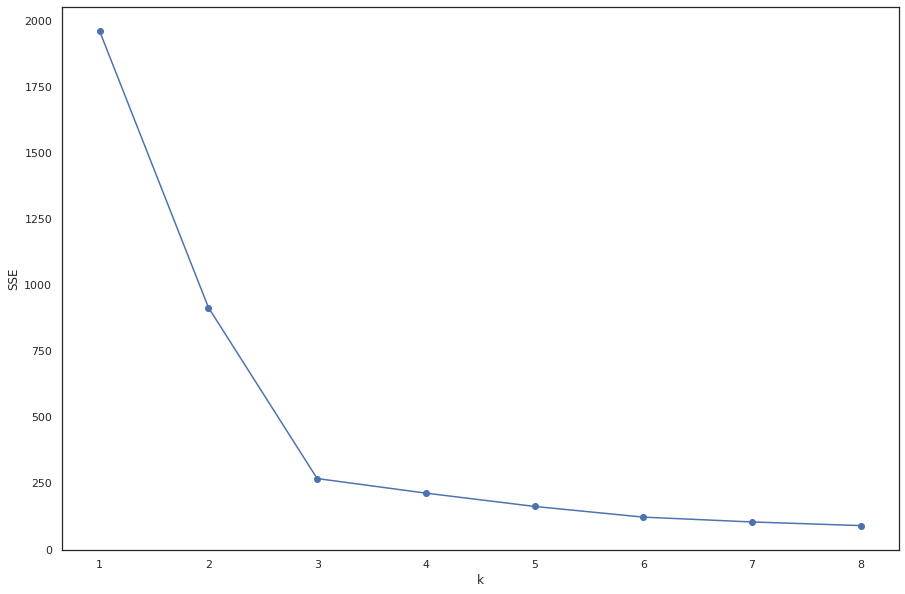

In [15]:
from sklearn.cluster import KMeans

# Use SSE to select k
# The SSE is defined as the Sum of the Squared Euclidean distances (SSE) of each point to its closest centroid.

SSE = []  
for k in range(1, 9):
    estimator = KMeans(n_clusters=k)  
    estimator.fit(data2)
    SSE.append(estimator.inertia_) # https://scikit-learn.org/stable/modules/clustering.html#k-means
X = range(1, 9)

plt.figure(figsize=(15, 10))
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X, SSE, 'o-')
plt.show()

The elbow is k=3

## An Advanced Example: K-Means for Image Compression

Use clustering to find the most representative few colors, and use cluster assignment to map the original 24-bit colors to a lower dimensional color space.

### Implementation using our k_means function

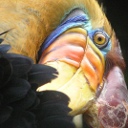

In [16]:
from IPython.display import Image

# If you use Google Colab, please create a folder called "data" in the Files panel at the 
# left-hand side of the brower, and upload bird_small.png to it
# Then, you need to modify the path to '/content/data/bird_small.png'

Image(filename='data/bird_small.png')

The raw pixel data has been pre-loaded for us so let's pull it in.

In [17]:
# If you use Google Colab, please create a folder called "data" in the Files panel at the 
# left-hand side of the brower, and upload bird_small.png to it
# Then, you need to modify the path to '/content/data/bird_small.png'

image_data = loadmat('data/bird_small.mat')
# image_data

In [18]:
A = image_data['A']
A.shape  # last dim is 3: RGB

(128, 128, 3)

Data preprocessing

In [19]:
# normalize value ranges
A = A / 255.

# reshape the array
X = np.reshape(A, (A.shape[0] * A.shape[1], A.shape[2]))
X.shape

(16384, 3)

Apply K-Means

In [21]:
# randomly initialize the centroids
initial_centroids = init_centroids(X, 16)  # X: (16384, 3), K = 16
print(initial_centroids.shape)  # initial_centroids: (16, 3)

# run the algorithm
assignments, centroids = k_means(X, initial_centroids, 10) 

# get the closest centroids one last time
assignments = find_closest_centroids(X, centroids)  # centroids: (16, 3)

# map each pixel to the centroid value
X_recovered = centroids[assignments.astype(int),:]
X_recovered.shape

(16, 3)


(16384, 3)

In [22]:
# reshape to the original dimensions
X_recovered = np.reshape(X_recovered, (A.shape[0], A.shape[1], A.shape[2]))
X_recovered.shape

(128, 128, 3)

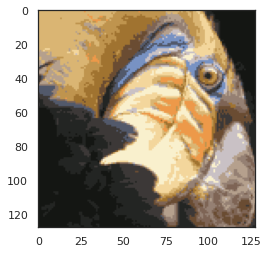

In [23]:
plt.imshow(X_recovered)
plt.show()

### Implementation using Scikit-Learn's KMeans

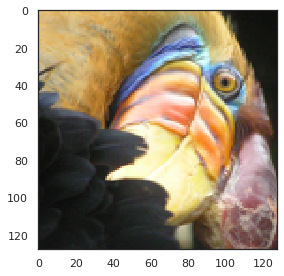

In [24]:
from skimage import io

# If you use Google Colab, please create a folder called "data" in the Files panel at the 
# left-hand side of the brower, and upload bird_small.png to it
# Then, you need to modify the path to '/content/data/bird_small.png'

# cast to float, you need to do this otherwise the color would be weird after clustring
pic = io.imread('data/bird_small.png') / 255.
io.imshow(pic)
plt.show()

In [25]:
pic.shape

(128, 128, 3)

In [26]:
# serialize data
data = pic.reshape(128*128, 3)

In [27]:
data.shape

(16384, 3)

In [28]:
from sklearn.cluster import KMeans 

model = KMeans(n_clusters=16, n_init=100)

In [29]:
model.fit(data)

KMeans(n_clusters=16, n_init=100)

In [30]:
centroids = model.cluster_centers_
print(centroids.shape)

C = model.predict(data)
print(C.shape)

(16, 3)
(16384,)


In [31]:
centroids[C].shape

(16384, 3)

In [32]:
compressed_pic = centroids[C].reshape((128,128,3))

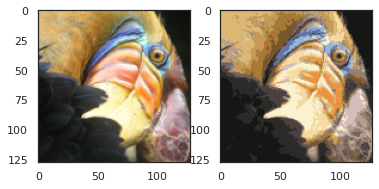

In [33]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(pic)
ax[1].imshow(compressed_pic)
plt.show()

## Hierarchical Clustering

In [34]:
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif']=['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False   # To show minus signs properly
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

In [35]:
iris = load_iris()
X = iris.data

In [36]:
# Set distance_threshold = 0, so that the complete dendrogram is computed
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)

Visualise the clustering results: Plot the endrogram

Ref: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html 

In [37]:
# Utility function

def plot_dendrogram(model, **kwargs):
    """
    Create the link matrix and draw the dendrogram
    """

    # Count the number of samples in each node of the dendrogram
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # draw the dendrogram
    dendrogram(linkage_matrix, **kwargs)

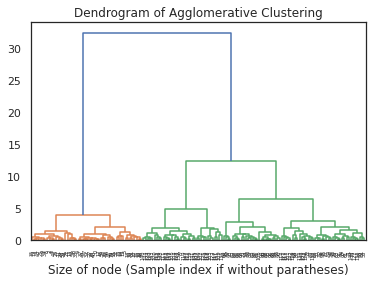

In [38]:
plt.title("Dendrogram of Agglomerative Clustering")
# Draw the dendrogram's first p levels
# plot_dendrogram(model, truncate_mode="level", p=3)
plot_dendrogram(model, truncate_mode="level")
plt.xlabel("Size of node (Sample index if without paratheses)")
plt.show()

## References:
- Andrew Ng. Machine Learning[EB/OL]. StanfordUniversity,2014.https://www.coursera.org/course/ml
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
- https://scikit-learn.org/stable/auto_examples/cluster